# Interpretability

Use these:
- https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb#scrollTo=t7I4NB_kqALg
- https://neelnanda-io.github.io/TransformerLens/transformer_lens.html

In [1]:
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the HookedTransformer code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

import plotly.io as pio
pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


/tmp/ipykernel_84905/41063028.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_84905/41063028.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from data_gen import get_data, format_data
from models import TransformerModel
import yaml
from munch import Munch
import time
import einops
from pprint import pprint

with open(f"configs/model_selection.yaml", "r") as yaml_file:
    args = Munch.fromYAML(yaml_file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv

In [4]:
model = TransformerModel(
    n_dims=len(args.data.data_alphas) + 1,
    n_positions=args.data.N,
    n_layer=args.model.n_layer,
    n_head=args.model.n_head,
    n_embd=args.model.n_embd
).to(device)
model.load_state_dict(torch.load("models/model_epoch1750_time16868839754.pth", map_location=torch.device('cpu'))) # TODO: Remove map_location
model.eval()

TransformerModel(
  (_read_in): Linear(in_features=3, out_features=64, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 64)
    (wpe): Embedding(21, 64)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Drop

In [5]:
data_dict = get_data(alphas=args.data.data_alphas, N=args.data.N, d_d=args.data.d_d, train_samp_per_class=2)#args.data.train_samp_per_class)

alphas, X, y = format_data(data_dict, train_samples_per_alpha=int(2 / len(args.data.data_alphas)))

Alphas: torch.Size([2]), X: torch.Size([2, 21, 3]), y: torch.Size([2])


## Turn into HookedTransformer

In [6]:
def converter():
    pass

config = {
    # "n_ctx": len(args.data.data_alphas) + 1,
    "n_ctx": args.data.N,
    "n_layers": args.model.n_layer,
    "n_heads": args.model.n_head,
    "d_model": args.model.n_embd,
    "d_head": args.model.n_embd // args.model.n_head,
    "d_mlp": args.model.n_embd * 4,
}

def converter(model, cfg: HookedTransformerConfig):
    state_dict = {}

    state_dict["embed.W_E"] = model._backbone.wte.weight
    state_dict["pos_embed.W_pos"] = model._backbone.wpe.weight

    for l in range(cfg.n_layers):
        state_dict[f"blocks.{l}.ln1.w"] = model._backbone.h[l].ln_1.weight
        state_dict[f"blocks.{l}.ln1.b"] = model._backbone.h[l].ln_1.bias

        # In GPT-2, q,k,v are produced by one big linear map, whose output is
        # concat([q, k, v])
        W = model._backbone.h[l].attn.c_attn.weight
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=1)
        W_Q = einops.rearrange(W_Q, "m (i h)->i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "m (i h)->i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "m (i h)->i m h", i=cfg.n_heads)

        state_dict[f"blocks.{l}.attn.W_Q"] = W_Q
        state_dict[f"blocks.{l}.attn.W_K"] = W_K
        state_dict[f"blocks.{l}.attn.W_V"] = W_V

        qkv_bias = model._backbone.h[l].attn.c_attn.bias
        qkv_bias = einops.rearrange(
            qkv_bias,
            "(qkv index head)->qkv index head",
            qkv=3,
            index=cfg.n_heads,
            head=cfg.d_head
        )
        state_dict[f"blocks.{l}.attn.b_Q"] = qkv_bias[0]
        state_dict[f"blocks.{l}.attn.b_K"] = qkv_bias[1]
        state_dict[f"blocks.{l}.attn.b_V"] = qkv_bias[2]

        W_O = model._backbone.h[l].attn.c_proj.weight
        W_O = einops.rearrange(W_O, "(i h) m->i h m", i=cfg.n_heads)
        state_dict[f"blocks.{l}.attn.W_O"] = W_O
        state_dict[f"blocks.{l}.attn.b_O"] = model._backbone.h[l].attn.c_proj.bias

        state_dict[f"blocks.{l}.ln2.w"] = model._backbone.h[l].ln_2.weight
        state_dict[f"blocks.{l}.ln2.b"] = model._backbone.h[l].ln_2.bias

        W_in = model._backbone.h[l].mlp.c_fc.weight
        state_dict[f"blocks.{l}.mlp.W_in"] = W_in
        state_dict[f"blocks.{l}.mlp.b_in"] = model._backbone.h[l].mlp.c_fc.bias

        W_out = model._backbone.h[l].mlp.c_proj.weight
        state_dict[f"blocks.{l}.mlp.W_out"] = W_out
        state_dict[f"blocks.{l}.mlp.b_out"] = model._backbone.h[l].mlp.c_proj.bias
    # state_dict["unembed.W_U"] = model._backbone.lm_head.weight.T # TODO: wth do we do?
    state_dict["unembed.W_U"] = model._backbone.wte.weight.T # TODO: wth do we do?

    state_dict["ln_final.w"] = model._backbone.ln_f.weight
    state_dict["ln_final.b"] = model._backbone.ln_f.bias

    return state_dict

In [7]:
hooked_model = HookedTransformer.from_custom("custom_model_seleciton_transformer", model, config, converter, device=device, fold_ln=False)
hooked_model

{'embed.W_E': tensor([[-0.0036,  0.0475, -0.0039,  ...,  0.0053,  0.0084, -0.0066],
        [ 0.0063, -0.0140,  0.0008,  ...,  0.0334, -0.0293, -0.0045],
        [ 0.0037, -0.0508, -0.0144,  ...,  0.0082,  0.0205, -0.0167],
        ...,
        [-0.0054,  0.0063, -0.0102,  ..., -0.0093, -0.0016, -0.0197],
        [-0.0057,  0.0021,  0.0037,  ...,  0.0070, -0.0013, -0.0329],
        [ 0.0266,  0.0200, -0.0240,  ..., -0.0221, -0.0047, -0.0156]]), 'pos_embed.W_pos': tensor([[ 0.0083, -0.1125, -0.2048,  ...,  0.4935, -0.2590, -1.0739],
        [-0.0880, -0.0361, -0.0123,  ...,  0.4994, -0.0402, -0.5680],
        [-0.0565,  0.1119, -0.0527,  ...,  0.4651, -0.1781, -0.3101],
        ...,
        [ 0.0013,  0.1388,  0.0213,  ..., -0.1129, -0.1951, -0.2362],
        [-0.1111,  0.0640, -0.0113,  ...,  0.0925, -0.1514, -0.3637],
        [ 0.2866, -0.4226,  0.0031,  ..., -0.6411,  0.1157, -0.4765]]), 'blocks.0.ln1.w': tensor([ 4.6181e-01, -4.4795e-03,  2.3191e-01, -5.5465e-03,  1.3582e-01,
      

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mi

## Interpretability

In [8]:
gpt2_logits, gpt2_cache = hooked_model.run_with_cache(model._read_in(X), remove_batch_dim=True)

pprint(gpt2_cache.keys())

torch.Size([2, 21, 64])
tensor([[[ 0.3754, -1.0686, -0.9056,  ..., -0.9583,  0.1032, -0.9345],
         [ 0.4269, -1.1271, -0.9217,  ..., -0.8962,  0.0813, -1.0676],
         [ 0.5201, -1.0812, -0.7511,  ..., -0.9307,  0.0509, -1.0930],
         ...,
         [ 0.8442, -1.2807, -0.9492,  ..., -0.7106, -0.1180, -1.5335],
         [ 0.2642, -1.0414, -0.8001,  ..., -0.9918,  0.1705, -0.8873],
         [-0.1078, -2.5586, -6.5273,  ...,  0.3588, -0.2155, -1.0532]],

        [[ 0.3804, -0.8159, -0.2143,  ..., -1.1940,  0.1626, -0.7550],
         [ 0.3519, -0.8776, -0.4062,  ..., -1.1391,  0.1589, -0.7770],
         [ 1.3380, -1.3284, -0.5031,  ..., -0.6134, -0.3064, -2.0438],
         ...,
         [ 0.6730, -1.2091, -1.0693,  ..., -0.7984, -0.0542, -1.2596],
         [ 0.6210, -0.6081,  0.8042,  ..., -1.3584,  0.1491, -0.9216],
         [ 0.5116, -1.4680, -2.1340,  ..., -0.5777, -0.0815, -1.2069]]])
dict_keys(['hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0

In [9]:
print(gpt2_cache["blocks.0.attn.hook_pattern"].shape)
print(gpt2_cache["blocks.0.attn.hook_pattern"])

torch.Size([2, 21, 21])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4919, 0.5081, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3583, 0.3591, 0.2826, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2884, 0.2786, 0.2247, 0.2083, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1133, 0.1097, 0.0950, 0.0692, 0.6128, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000

In [17]:
# html = cv.attention.attention_patterns(tokens=X[0], attention=gpt2_cache["blocks.0.attn.hook_pattern"])

# print(html)
# from IPython.display import HTML
# HTML(html)

# TODO: Get cv to work!!!
cv.attention.attention_patterns(tokens=X[0], attention=gpt2_cache["blocks.0.attn.hook_pattern"])

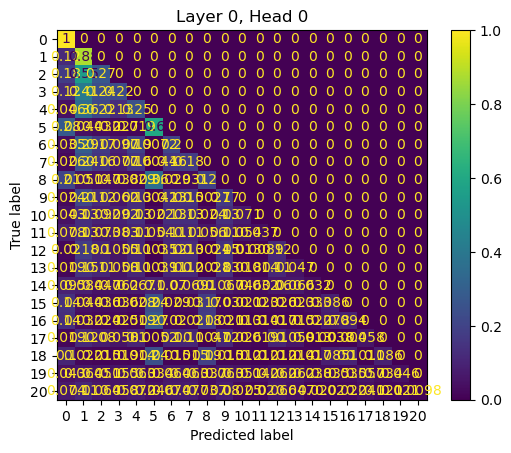

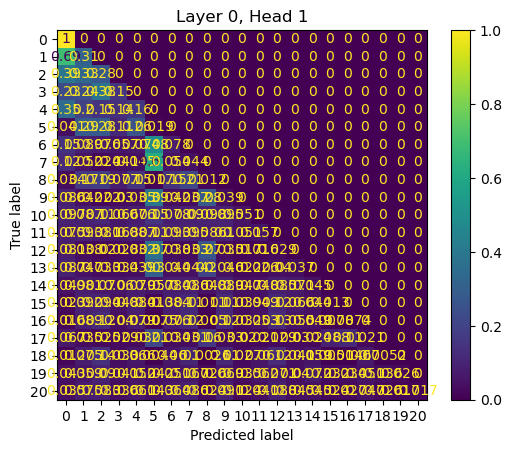

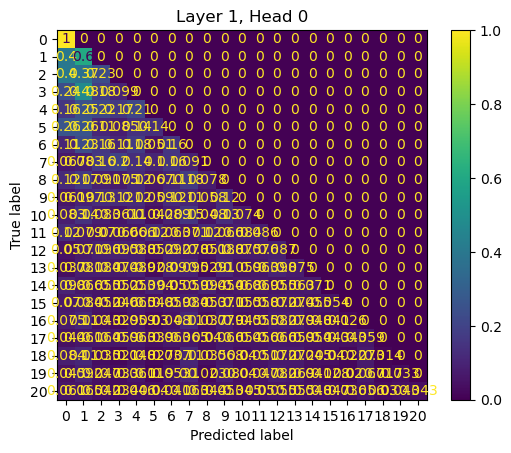

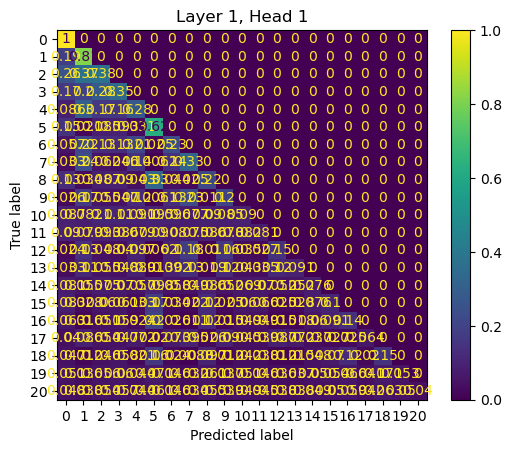

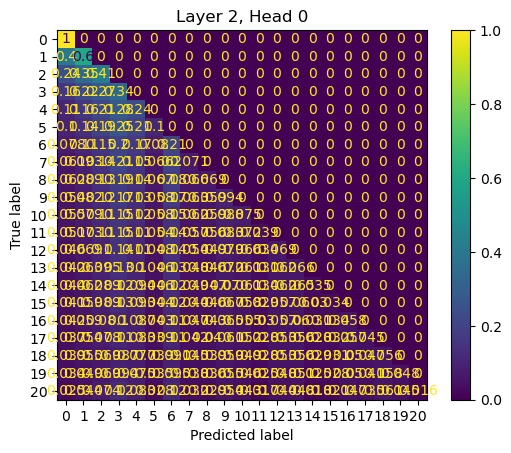

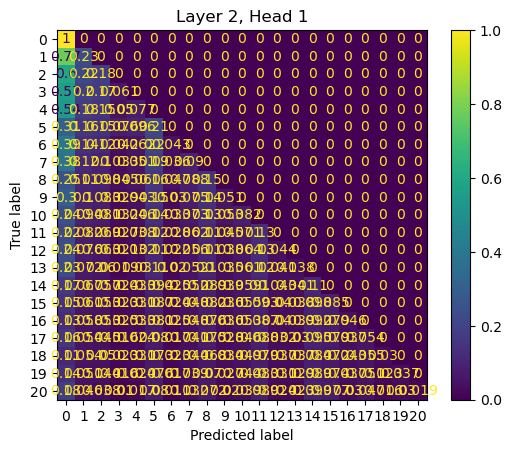

In [18]:


from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for layer in range(3):
    for head in range(2):
        disp = ConfusionMatrixDisplay(confusion_matrix=gpt2_cache[f"blocks.{layer}.attn.hook_pattern"][head].numpy(), display_labels=range(21))
        disp.plot()
        plt.title(f"Layer {layer}, Head {head}")
        plt.show()